# Read Dataset

In [1]:
SF_DIR_PATH = './data/cabspottingdata'
FILE_PREFIX = "new_"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
taxi_dataset = dict()

for _root, _dirs, files in os.walk(SF_DIR_PATH):
    for filename in files:
        # pass the none-data file
        if not filename.startswith(FILE_PREFIX):
            continue
        
        # extract data from csv file
        filepath = os.path.join(SF_DIR_PATH, filename)
        taxi_data = pd.read_csv(
            filepath,
            sep=' ',
            index_col=False,
            names=["latitude", "longitude", "time"],
            usecols=[0, 1, 3])
        # taxi_data["time"] = pd.to_datetime(taxi_data["time"], unit="s")
        taxi_id = os.path.splitext(filename)[0][4::]

        taxi_dataset[taxi_id] = taxi_data

print("The number of taxis:", len(taxi_dataset))

The number of taxis: 536


In [4]:
taxi_dataset["abboip"].head()

latitude  longitude        time
0  37.75134 -122.39488  1213084687
1  37.75136 -122.39527  1213084659
2  37.75199 -122.39460  1213084540
3  37.75080 -122.39346  1213084489
4  37.75015 -122.39256  1213084237

Check if there exists nan

In [5]:
any([data.isnull().all().all() for data in taxi_dataset.values()])

False

In [6]:
locations = pd.concat([data[["latitude", "longitude"]] for data in taxi_dataset.values()])
locations.to_csv("./data/SF/locations.csv", index=False)

# Find Potential Traffic Lights' Locations

Metric: If the vehicle waits at a location for 15-120 seconds, such a behavior triggers the application to issue a detection report (of a traffic light).

**Define** 'wait at a location': the sum of two adjacent coordinates' difference is less than 5m, i.e. approximately 4.5e-5 degree.

## Choose Participants

Randomly choose 100 participants:

In [7]:
import random

chosen_participants = set(random.sample(taxi_dataset.keys(), 100))
taxi_dataset = { id: data for id, data in taxi_dataset.items() if id in chosen_participants }
len(taxi_dataset)

100

Have a look at the area first.

In [8]:
locations = pd.concat([data[["latitude", "longitude"]] for data in taxi_dataset.values()])
locations.describe()

latitude     longitude
count  2.054738e+06  2.054738e+06
mean   3.776333e+01 -1.224128e+02
std    5.308470e-02  3.593295e-02
min    3.466292e+01 -1.266117e+02
25%    3.775415e+01 -1.224258e+02
50%    3.778065e+01 -1.224113e+02
75%    3.779023e+01 -1.224003e+02
max    5.030546e+01 -1.220000e+02

In [9]:
def wait_at_the_same_location(coordinates_pre, coordinates_next):
    next = coordinates_next.reset_index(drop=True)
    pre = coordinates_pre.reset_index(drop=True)
    return (next - pre).pow(2).sum(axis=1).pow(0.5) <= 4.5e-5

def detect_waiting_locations(taxi_data, id):
    # sort by time ascendingly
    taxi_data = taxi_data.set_index(["time"]) # a time-indexed copy
    taxi_data.sort_index(inplace=True)
    taxi_data.reset_index(inplace=True)

    # calculate the adjacent time differences
    taxi_time = taxi_data["time"]
    intervals = taxi_time[1:].reset_index(drop=True) - taxi_time[:-1].reset_index(drop=True)

    coordinates = taxi_data[["latitude", "longitude"]]
    location_mask = wait_at_the_same_location(coordinates[:-1], coordinates[1:])
    waiting_locations = coordinates[:-1][location_mask]

    # accumulate time_diff if index is adjacent in waiting_locations
    previous_index = -2
    for index, _location in waiting_locations.iterrows():
        index = int(index)
        if index == previous_index + 1:
            intervals.iloc[index] += intervals.iloc[previous_index]
        previous_index = index
    del previous_index

    # filter time intervals that meet the metric
    time_mask = (intervals <= 120) & (intervals >= 15)

    mask = time_mask & location_mask
    taxi_data["id"] = id
    return taxi_data[:-1][mask]


waiting_location_set = [detect_waiting_locations(taxi_dataset[id], id) for id in taxi_dataset.keys()]
waiting_location_set = pd.concat(waiting_location_set)
waiting_location_set.reset_index(drop=True, inplace=True)
waiting_location_set.describe()

time       latitude      longitude
count  1.205340e+05  120534.000000  120534.000000
mean   1.212041e+09      37.758821    -122.413893
std    5.869348e+05       0.055099       0.034760
min    1.211018e+09      37.235660    -122.564110
25%    1.211538e+09      37.751460    -122.429040
50%    1.212047e+09      37.776510    -122.410720
75%    1.212549e+09      37.789400    -122.395360
max    1.213089e+09      37.995300    -122.000800

# Clustering

Cluster waiting locations to infer possible traffic light locations.

Limit an area of [[37.7, 37.8], [-122.5, -122.4]].

In [10]:
from sklearn.cluster import DBSCAN
import numpy as np

# limit in a area
X = waiting_location_set
X = X[(X["latitude"] >= 37.7) & (X["latitude"] <= 37.8) & (X["longitude"] >= -122.5) & (X["longitude"] <= -122.4)]

db = DBSCAN(eps=4.5e-4, min_samples=3).fit(X[["latitude", "longitude"]]) # eps is about 10m
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1550
Estimated number of noise points: 2804


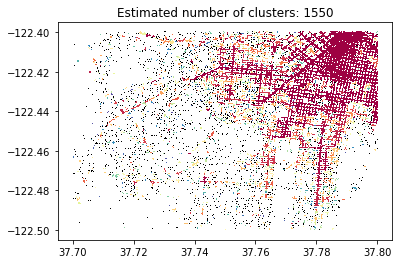

In [11]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = (0, 0, 0, 1)
    else:
        col = tuple(col)

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy["latitude"], xy["longitude"], ',', color=col)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy["latitude"], xy["longitude"], ',', color=col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [12]:
X["cluster-id"] = db.labels_
X.describe()

time      latitude     longitude    cluster-id
count  7.147400e+04  71474.000000  71474.000000  71474.000000
mean   1.212037e+09     37.775539   -122.426235    132.651566
std    5.879032e+05      0.019749      0.021285    304.052563
min    1.211019e+09     37.700000   -122.499990     -1.000000
25%    1.211535e+09     37.765300   -122.436190      1.000000
50%    1.212041e+09     37.782610   -122.420660      1.000000
75%    1.212546e+09     37.789070   -122.409700     45.000000
max    1.213088e+09     37.800000   -122.400000   1549.000000

In [13]:
X.to_csv("./data/SF/waiting_positions.csv", index=False)

## Cluster Center

Figure out the centers of these clusters. These centers might be potential traffic light positions.

In [27]:
centers = X.groupby("cluster-id")[["latitude", "longitude"]].agg([np.mean, np.std, len])
centers.drop(-1, inplace=True)
centers.head()

latitude                      longitude                   
                 mean       std      len        mean       std      len
cluster-id                                                             
0           37.774852  0.002131   3012.0 -122.433985  0.005317   3012.0
1           37.788491  0.006373  36922.0 -122.414532  0.009982  36922.0
2           37.745444  0.003282    635.0 -122.420595  0.001721    635.0
3           37.779615  0.000528     53.0 -122.427175  0.000373     53.0
4           37.770347  0.002364   1301.0 -122.448275  0.003059   1301.0

In [28]:
centers["report-num"] = centers[('latitude', 'len')]
del centers[('latitude', 'len')]
del centers[('longitude', 'len')]
centers.sort_values(by=["report-num"], inplace=True, ascending=False)
centers.head()

latitude             longitude           report-num
                 mean       std        mean       std           
cluster-id                                                      
1           37.788491  0.006373 -122.414532  0.009982    36922.0
0           37.774852  0.002131 -122.433985  0.005317     3012.0
18          37.760070  0.004470 -122.420315  0.002316     2328.0
9           37.763639  0.003130 -122.432755  0.002784     2096.0
4           37.770347  0.002364 -122.448275  0.003059     1301.0

In [16]:
centers.describe()

latitude                 longitude                 report_num
              mean          std         mean          std              
count  1498.000000  1498.000000  1498.000000  1498.000000   1498.000000
mean     37.756781     0.000162  -122.444557     0.000170     49.548732
std       0.023026     0.000345     0.025943     0.000357   1168.440079
min      37.700998     0.000000  -122.499862     0.000000      3.000000
25%      37.741887     0.000037  -122.466138     0.000038      3.000000
50%      37.758695     0.000098  -122.442457     0.000098      5.000000
75%      37.775683     0.000208  -122.425356     0.000202     11.000000
max      37.799984     0.010683  -122.400153     0.009786  45038.000000

## Dump Clustering Centers

In [30]:
centers_ = pd.DataFrame()
centers_[["latitude", "longitude"]] = centers[[("latitude", "mean"), ("longitude", "mean")]]
centers_[["latitude-std", "longitude-std"]] = centers[[("latitude", "std"), ("longitude", "std")]]
centers_["report-num"] = centers["report-num"]
centers_["range"] = (centers_["latitude-std"].pow(2) + centers_["longitude-std"].pow(2)).pow(0.5) * 85.39e3

centers_ = centers_.reset_index()
# centers_.to_csv("centers.csv", index=False)
centers_.head()

cluster-id   latitude   longitude  latitude-std  longitude-std  report-num  \
0           1  37.788491 -122.414532      0.006373       0.009982     36922.0   
1           0  37.774852 -122.433985      0.002131       0.005317      3012.0   
2          18  37.760070 -122.420315      0.004470       0.002316      2328.0   
3           9  37.763639 -122.432755      0.003130       0.002784      2096.0   
4           4  37.770347 -122.448275      0.002364       0.003059      1301.0   

         range  
0  1011.290531  
1   489.087227  
2   429.885765  
3   357.707182  
4   330.109965

In [38]:
# take first 100 centers (by report num)
centers_100 = centers_[(centers_["range"] >= 1) & (centers_["range"] <= 100)]
centers_100 = centers_100[centers_100["report-num"] >= 3] # required by the algorithm
centers_100 = centers_100.iloc[0:100,:]
centers_100.to_csv("./data/SF/centers_100.csv",index=False)
centers_100.head()

cluster-id   latitude   longitude  latitude-std  longitude-std  \
8          130  37.768599 -122.420255      0.000477       0.000203   
12          26  37.782169 -122.449887      0.000221       0.000617   
15          63  37.748571 -122.416157      0.000233       0.000331   
17          36  37.773164 -122.418618      0.000541       0.000586   
19         326  37.768666 -122.415912      0.000420       0.000255   

    report-num      range  
8        375.0  44.307856  
12       306.0  55.924798  
15       287.0  34.541064  
17       224.0  68.106544  
19       193.0  41.963646